In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import datetime
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from bs4 import BeautifulSoup
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
csv = pd.read_csv('data/robotics.csv.zip', index_col='id')
print(csv.shape)
csv.head()

(2771, 3)


,title,content,tags
id,,,
1,What is the right approach to write the spin c...,<p>Imagine programming a 3 wheel soccer robot....,soccer control
2,How can I modify a low cost hobby servo to run...,"<p>I've got some hobby servos (<a href=""http:/...",control rcservo
3,What useful gaits exist for a six legged robot...,"<p><a href=""http://www.oricomtech.com/projects...",gait walk
4,Good Microcontrollers/SOCs for a Robotics Project,<p>I am looking for a starting point for my pr...,microcontroller arduino raspberry-pi
5,Nearest-neighbor data structure for non-Euclid...,<p>I'm trying to implement a nearest-neighbor ...,motion-planning rrt


In [3]:
def uniq_tags(df):
    tags = set()
    df['tags'].str.split(' ').apply(tags.update)
    return tags

In [4]:
def words_frequencies(df, column):
    st = LancasterStemmer() # reduce plutal, gerunts and so on...
    freq = {}
    for i, row in df.iterrows():
        words = row[column].split(' ')
        for word in words:
            word = st.stem(word)
            freq[word] = freq.get(word, 0) + 1

    return freq

In [5]:
def prepare_text(text):
    cleantext = re.sub("<.*?>", "", text).lower().replace('\n', '. ')
    splitter = re.compile("[^a-zA-Z0-9_\\+\\-/]")
    words = splitter.split(cleantext)
    stops = set(stopwords.words("english"))
    meaningful_words = [w.strip() for w in words if not w in stops]
    return " ".join(filter(None, meaningful_words))

In [104]:
def remove_html(text):
    # return re.sub(r'\s+', ' ', re.sub("<.*?>", "", text)).lower().strip()
    return re.sub("[0-9]+", "", re.sub(r'\s+', ' ', BeautifulSoup(text, "html.parser").get_text()).lower().strip())

In [7]:
def prepare_data(df, func):
    res = pd.DataFrame(index=df.index)
    res['tags'] = df['tags']
    res['title'] = df['title'].apply(func)
    res['content'] = df['content'].apply(func)
    return res

In [8]:
def prepare_test_data(df, func):
    res = pd.DataFrame(index=df.index)
    res['title'] = df['title'].apply(func)
    res['content'] = df['content'].apply(func)
    return res

In [9]:
data = prepare_data(csv, remove_html)
data.head()

,tags,title,content
id,,,
1,soccer control,what is the right approach to write the spin c...,imagine programming a 3 wheel soccer robot. wh...
2,control rcservo,how can i modify a low cost hobby servo to run...,i've got some hobby servos (power hd 1501mgs) ...
3,gait walk,what useful gaits exist for a six legged robot...,http://www.oricomtech.com/projects/leg-time.ht...
4,microcontroller arduino raspberry-pi,good microcontrollers/socs for a robotics project,i am looking for a starting point for my proje...
5,motion-planning rrt,nearest-neighbor data structure for non-euclid...,i'm trying to implement a nearest-neighbor str...


In [10]:
tag_freq = words_frequencies(data, 'tags')
content_freq = words_frequencies(data, 'content')
title_freq = words_frequencies(data, 'title')

In [11]:
tags = pd.DataFrame(list(tag_freq.values()), columns=['count'], index=tag_freq.keys())
tags.sort_values(['count'], ascending=False).head(10)

,count
quadcopt,306
mobile-robot,295
arduino,282
mot,273
control,255
sens,204
robotic-arm,180
pid,162
loc,125
microcontrol,117


In [12]:
tags.describe()

,count
count,228.000000
mean,28.596491
std,49.071416
min,1.000000
25%,4.000000
50%,11.000000
75%,28.750000
max,306.000000


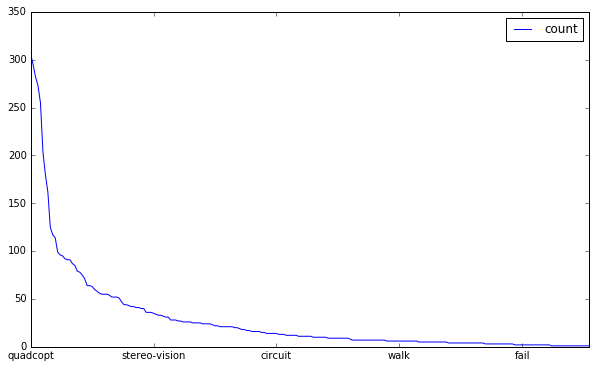

In [13]:
tags.sort_values(['count'], ascending=False).plot()

In [14]:
tags['count'].loc[lambda c: c > 100].count()

11

In [15]:
titles = pd.DataFrame(list(title_freq.values()), columns=['count'], index=title_freq.keys())
titles.sort_values(['count'], ascending=False).head(10)

,count
a,873
to,728
for,562
the,485
robot,450
of,446
how,432
and,360
in,344
with,302


In [16]:
titles.describe()

,count
count,3944.000000
mean,5.742394
std,29.794112
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,873.000000


In [17]:
contents = pd.DataFrame(list(content_freq.values()), columns=['count'], index=content_freq.keys())
contents.sort_values(['count'], ascending=False).head(10)

,count
,67937
the,21662
.,17221
to,12575
i,11660
a,9779
and,7670
is,6839
of,6614
in,4602


In [18]:
contents.describe()

,count
count,43141.000000
mean,11.519228
std,378.647441
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,67937.000000


In [19]:
intersections_with_title=set(titles.index) & set(tags.index)
intersections_with_content=set(contents.index) & set(tags.index)
intersection_with_all = (set(contents.index) | set(titles.index)) & set(tags.index)
print("Tags {}".format(len(tags.index)))
print("Titles {}".format(len(intersections_with_title)))
print("Contents {}".format(len(intersections_with_content)))
print("All {}".format(len(intersection_with_all)))

Tags 228
Titles 158
Contents 170
All 173


In [20]:
# Set of tags that don't appear in niether in title or content 
set(tags.index) - (set(contents.index) | set(titles.index))

{'3d-model',
 '3d-reconstruction',
 'acoustic-rangefinder',
 'activerobot',
 'air-muscle',
 'artificial-intelligence',
 'battle-bot',
 'beagle-bon',
 'brushless-motor',
 'data-association',
 'deduced-reckoning',
 'digital-audio',
 'distributed-systems',
 'dynamic-programming',
 'embedded-systems',
 'first-robotics',
 'force-sensor',
 'forward-kinematics',
 'hall-sensor',
 'heat-manage',
 'hri',
 'industrial-robot',
 'information-gain',
 'irobot-create',
 'linear-bearing',
 'lithium-polymer',
 'logic-control',
 'low-latency',
 'machine-learning',
 'motion-planning',
 'multi-agent',
 'not-exactly-c',
 'occupancygrid',
 'operating-systems',
 'particle-filter',
 'precise-positioning',
 'product-of-exponentials',
 'programming-languages',
 'quadrature-encoder',
 'raspberry-pi',
 'rcservo',
 'reference-request',
 'reinforcement-learning',
 'roboti-arm',
 'robotic-arm',
 'sensor-er',
 'sensor-fusion',
 'speech-processing',
 'stepper-driv',
 'ultrasonic-sensors',
 'uncanny-valley',
 'untag',
 

In [21]:
for i, row in data.iterrows():
    tags = set(row['tags'].split(' '))
    words = set(row['content'].split(' ')) | set(row['title'].split(' '))
    intersection = tags & words
    data.ix[i, 'intersection'] = len(intersection) / len(tags)
data.head()

,tags,title,content,intersection
id,,,,
1,soccer control,what is the right approach to write the spin c...,imagine programming a 3 wheel soccer robot. wh...,0.500000
2,control rcservo,how can i modify a low cost hobby servo to run...,i've got some hobby servos (power hd 1501mgs) ...,0.500000
3,gait walk,what useful gaits exist for a six legged robot...,http://www.oricomtech.com/projects/leg-time.ht...,0.000000
4,microcontroller arduino raspberry-pi,good microcontrollers/socs for a robotics project,i am looking for a starting point for my proje...,0.333333
5,motion-planning rrt,nearest-neighbor data structure for non-euclid...,i'm trying to implement a nearest-neighbor str...,0.500000


In [22]:
data.describe()

,intersection
count,2771.000000
mean,0.376639
std,0.367761
min,0.000000
25%,0.000000
50%,0.333333
75%,0.666667
max,1.000000


In [23]:
import string, itertools
from nltk import word_tokenize, sent_tokenize, pos_tag_sents, tree2conlltags
from  nltk.chunk.regexp import RegexpParser
import itertools, nltk, string

In [24]:
grammar = r'KT: {(<JJ>* <NN.*>+ <IN>)? <JJ>* <NN.*>+}'
# grammar = r"""
#     NBAR:
#         {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
#     NP:
#         {<NBAR>}
#         {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
# """
stop_words = stopwords.words('english')
punct = string.punctuation
chunker = RegexpParser(grammar)
text = data.ix[2,'content']
text

"i've got some hobby servos (power hd 1501mgs) and i'd like to be able to control them (via an arduino) so they will either go to the angle i set, or put them in a 'free running' mode, where the load will take them wherever it goes.. . is this even possible, or am i just going to end up stripping the gears?. . my first thought is to simply kill the power to the servo, but the force required to move them in that state is more than i'd like.. . if it is possible, am i looking at a hardware change, or could i do it in software?. "

In [25]:
tagged_sents  = pos_tag_sents([word_tokenize(sent) for sent in sent_tokenize(text)])
tuples = [tree2conlltags(chunker.parse(tagged_sent)) for tagged_sent in tagged_sents]
all_chunks = list(itertools.chain.from_iterable(tuples)) # they said it's optimization for loops
all_chunks

[('i', 'NN', 'B-KT'),
 ("'ve", 'VBP', 'O'),
 ('got', 'VBN', 'O'),
 ('some', 'DT', 'O'),
 ('hobby', 'NN', 'B-KT'),
 ('servos', 'NN', 'I-KT'),
 ('(', '(', 'O'),
 ('power', 'NN', 'B-KT'),
 ('hd', 'RB', 'O'),
 ('1501mgs', 'CD', 'O'),
 (')', ')', 'O'),
 ('and', 'CC', 'O'),
 ('i', 'JJ', 'O'),
 ("'d", 'MD', 'O'),
 ('like', 'VB', 'O'),
 ('to', 'TO', 'O'),
 ('be', 'VB', 'O'),
 ('able', 'JJ', 'O'),
 ('to', 'TO', 'O'),
 ('control', 'VB', 'O'),
 ('them', 'PRP', 'O'),
 ('(', '(', 'O'),
 ('via', 'IN', 'O'),
 ('an', 'DT', 'O'),
 ('arduino', 'NN', 'B-KT'),
 (')', ')', 'O'),
 ('so', 'IN', 'O'),
 ('they', 'PRP', 'O'),
 ('will', 'MD', 'O'),
 ('either', 'RB', 'O'),
 ('go', 'VB', 'O'),
 ('to', 'TO', 'O'),
 ('the', 'DT', 'O'),
 ('angle', 'NN', 'B-KT'),
 ('i', 'NN', 'I-KT'),
 ('set', 'VBN', 'O'),
 (',', ',', 'O'),
 ('or', 'CC', 'O'),
 ('put', 'VB', 'O'),
 ('them', 'PRP', 'O'),
 ('in', 'IN', 'O'),
 ('a', 'DT', 'O'),
 ("'free", 'JJ', 'O'),
 ('running', 'VBG', 'O'),
 ("'", "''", 'O'),
 ('mode', 'NN', 'B-KT'),
 

In [26]:
import nltk
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    #word = stemmer.stem_word(word)
    word = lemmatizer.lemmatize(word)
    return word

In [27]:
def group_func(t):
        (word,pos,chunk) = t
        return chunk != 'O'
    
punct = set(string.punctuation)
stop_words = set(nltk.corpus.stopwords.words('english'))
grammar=r'KT: {(<JJ>* <NN.*>+ <IN>)? <JJ>* <NN.*>+}'
chunker = nltk.chunk.regexp.RegexpParser(grammar)

def extract_candidate_chunks(text):
    # exclude candidates that are stop words or entirely punctuation
    # tokenize, POS-tag, and chunk using regular expressions
    tagged_sents = nltk.pos_tag_sents(nltk.word_tokenize(sent) for sent in nltk.sent_tokenize(text))
    all_chunks = [nltk.chunk.tree2conlltags(chunker.parse(tagged_sent)) 
                  for tagged_sent in tagged_sents]
    all_chunks = list(itertools.chain.from_iterable(all_chunks))
    # join constituent chunk words into a single chunked phrase
    candidates = [' '.join(word for word, pos, chunk in group).lower()
                  for key, group in itertools.groupby(all_chunks, group_func) if key]

    return set([cand for cand in candidates
            if cand not in stop_words and not all(char in punct for char in cand) and len(cand) > 2])

In [28]:
extract_candidate_chunks(text)

{'angle i',
 'arduino',
 'first thought',
 'force',
 'gears',
 'hardware change',
 'hobby servos',
 'load',
 'mode',
 'power',
 'servo',
 'software',
 'state'}

In [29]:
def extract_candidate_words(text, good_tags=set(['JJ','JJR','JJS','NN','NNP','NNS','NNPS'])):
    # exclude candidates that are stop words or entirely punctuation
    punct = set(string.punctuation)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    # tokenize and POS-tag words
    tagged_words = itertools.chain.from_iterable(nltk.pos_tag_sents(nltk.word_tokenize(sent)
                                                                    for sent in nltk.sent_tokenize(text)))
    # filter on certain POS tags and lowercase all words
    candidates = [word.lower() for word, tag in tagged_words
                  if tag in good_tags and word.lower() not in stop_words
                  and not all(char in punct for char in word) and len(tag) > 2]

    return candidates

In [30]:
extract_candidate_words(text)

['gears']

In [31]:
def score_keyphrases_by_textrank(text, n_keywords=0.05):
    from itertools import takewhile, tee
    import networkx, nltk
    
    # tokenize for all words, and extract *candidate* words
    words = [word.lower()
             for sent in nltk.sent_tokenize(text)
             for word in nltk.word_tokenize(sent)]
    candidates = extract_candidate_chunks(text)
    # build graph, each node is a unique candidate
    graph = networkx.Graph()
    graph.add_nodes_from(set(candidates))
    # iterate over word-pairs, add unweighted edges into graph
    def pairwise(iterable):
        """s -> (s0,s1), (s1,s2), (s2, s3), ..."""
        a, b = tee(iterable)
        next(b, None)
        return zip(a, b)
    for w1, w2 in pairwise(candidates):
        if w2:
            graph.add_edge(*sorted([w1, w2]))
    # score nodes using default pagerank algorithm, sort by score, keep top n_keywords
    ranks = networkx.pagerank(graph)
    if 0 < n_keywords < 1:
        n_keywords = int(round(len(candidates) * n_keywords))
    word_ranks = {word_rank[0]: word_rank[1]
                  for word_rank in sorted(ranks.items(), key=lambda x: x[1], reverse=True)[:n_keywords]}
    keywords = set(word_ranks.keys())
    # merge keywords into keyphrases
    keyphrases = {}
    j = 0
    for i, word in enumerate(words):
        if i < j:
            continue
        if word in keywords:
            kp_words = list(takewhile(lambda x: x in keywords, words[i:i+10]))
            avg_pagerank = sum(word_ranks[w] for w in kp_words) / float(len(kp_words))
            keyphrases[' '.join(kp_words)] = avg_pagerank
            # counter as hackish way to ensure merged keyphrases are non-overlapping
            j = i + len(kp_words)
    
    return [tag for tag, score in sorted(keyphrases.items(), key=lambda x: x[1], reverse=True)]

In [32]:
score_keyphrases_by_textrank(text, 0.5)

['power', 'servo', 'mode', 'force', 'software']

In [33]:
for i, row in data.iterrows():
    tags = score_keyphrases_by_textrank("{} {}".format(data.ix[i, 'title'], data.ix[i, 'content']), 0.4)
    data.ix[i, 'predictions'] = ' '.join(tags)
data.head()

,tags,title,content,intersection,predictions
id,,,,,
1,soccer control,what is the right approach to write the spin c...,imagine programming a 3 wheel soccer robot. wh...,0.500000,void goal number motorspeed software pid devid...
2,control rcservo,how can i modify a low cost hobby servo to run...,i've got some hobby servos (power hd 1501mgs) ...,0.500000,servo power force mode
3,gait walk,what useful gaits exist for a six legged robot...,http://www.oricomtech.com/projects/leg-time.ht...,0.000000,pros wave tripod cons
4,microcontroller arduino raspberry-pi,good microcontrollers/socs for a robotics project,i am looking for a starting point for my proje...,0.333333,ones project observation
5,motion-planning rrt,nearest-neighbor data structure for non-euclid...,i'm trying to implement a nearest-neighbor str...,0.500000,something space dimension


In [113]:
test = pd.read_csv('data/test.csv', index_col='id')
test.head()

,title,content
id,,
1,What is spin as it relates to subatomic partic...,<p>I often hear about subatomic particles havi...
2,What is your simplest explanation of the strin...,<p>How would you explain string theory to non ...
3,"Lie theory, Representations and particle physics",<p>This is a question that has been posted at ...
7,Will Determinism be ever possible?,<p>What are the main problems that we need to ...
9,Hamilton's Principle,<p>Hamilton's principle states that a dynamic ...


In [109]:
test_data = prepare_test_data(test, remove_html)
test_data.head()

KeyboardInterrupt: 

In [36]:
test.shape

(81926, 2)

In [105]:
remove_html(test.ix[29,'content'])

'i recently encountered a puzzle where a person drove  miles at mph, then drove back the same  miles at mph. the average of the speeds is $\\frac{mph+mph}{} = mph$, so the total trip time should be $\\frac{mi}{mph} = . hours$. but the trip actually took  hours. why is that, and what is the correct way to calculate the average speed?'

In [50]:
test_data.ix[29,'content']

'i recently encountered a puzzle where a person drove 120 miles at 40mph, then drove back the same 120 miles at 60mph. the average of the speeds is $\\frac{40mph+60mph}{2} = 50mph$, so the total trip time should be $\\frac{240mi}{50mph} = 4.8 hours$. but the trip actually took 5 hours. why is that, and what is the correct way to calculate the average speed?'

In [63]:
soup = BeautifulSoup(test.ix[31,'content'], 'html.parser')
soup.get_text()

"What is Einstein's theory of Special relativity, in terms a lay person can follow?\n"

Use https://code.google.com/archive/p/opendetex/wikis/Usage.wiki to remove latex